In [1]:
!pip install langchain langgraph langchain_community langchain_groq rizaio graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.2/138.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.8 MB/s eta 0:00:00


In [2]:
import os
from google.colab import userdata

groq_api_key = userdata.get('GROQ_API_KEY')

os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')
os.environ['RIZA_API_KEY'] = userdata.get('RIZA_API_KEY')

In [3]:
from typing import Annotated, List
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.riza.command import ExecPython

In [5]:
from langchain_groq import ChatGroq

llm = ChatGroq(groq_api_key=groq_api_key, model="gemma2-9b-it")

In [6]:
llm.invoke("hi").content

'Hi there! 👋\n\nWhat can I do for you today? 😊\n'

In [7]:
tool_tavily = TavilySearchResults(max_results=2)

tool_code_interpreter = ExecPython()

tools = [tool_tavily, tool_code_interpreter]

In [9]:
llm_with_tools = llm.bind_tools(tools=tools)

In [10]:
llm_with_tools.invoke("Give ne current trending events in USA?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gpa4', 'function': {'arguments': '{"query":"current trending events in USA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 1143, 'total_tokens': 1234, 'completion_time': 0.165454545, 'prompt_time': 0.036346478, 'queue_time': 0.023732035, 'total_time': 0.201801023}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fd4e3aab-0714-487f-a5cf-ee9e45d32572-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current trending events in USA'}, 'id': 'call_gpa4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1143, 'output_tokens': 91, 'total_tokens': 1234})

In [12]:
response = llm.invoke("""### what is the output of print(['a']+2)""")

if hasattr(response, 'content'):
  print("AI Response Content:", response.content)
else:
  print("AI Response:", response)

AI Response Content: The output of `print(['a'] + 2)` will be:

```
['a', 2]
```

Here's why:

* **`['a']`:** This is a list containing the single element 'a'.
* **`+ 2`:**  The `+` operator, when used with a list, performs list concatenation.  Since 2 is an integer, it's converted to a string before being added to the list.

Therefore, the operation results in a new list containing 'a' and the string representation of 2 ('2'). 


Let me know if you have any other Python questions!



In [25]:
class State(TypedDict):
  messages: Annotated[List, add_messages]

In [26]:
def chatbot(state: State):
  return {"messages": [llm_with_tools.invoke(state['messages'])]}

In [27]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile()

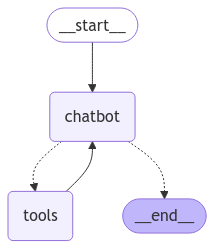

In [28]:
from IPython.display import display, Image

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [29]:
def stream_graph_updates(user_input: str):
  initial_state = {"messages": [("user", user_input)]}
  for event in graph.stream(initial_state):
    for value in event.values():
      print("Assistant:", value['messages'][-1].content)

In [30]:
while True:
  try:
    user_input = input("User: ")

    if user_input.lower() in ["quit", "q", "exit"]:
      print("Good Bye!")
      break

    stream_graph_updates(user_input)

  except Exception as e:
    print("Exception occured during processing:", e)
    stream_graph_updates(user_input)
    break

User: hi
Assistant: 
Assistant: [{"url": "https://www.britannica.com/dictionary/hi", "content": "Hi Definition & Meaning | Britannica Dictionary The Britannica Dictionary mobile search Word of the Day Core Vocabulary Browse the Dictionary Britannica Homepage Word of the Day Core Vocabulary Browse the Dictionary The Britannica Dictionary hi hi (interjection) HI (abbreviation) hi–fi (noun) high tech (noun) hi /ˈhaɪ/ interjection hi /ˈhaɪ/ interjection Britannica Dictionary definition of HI Hi, how are you? Aren't you going to say hi to [=greet] him? What are the plural forms of check-in, passerby, and spoonful?See the answer » Vocabulary Quiz Test your word power Take the Quiz » Take our visual quiz Test Your Knowledge » WORD OF THE DAY imprint: a mark created by pressing against a surfaceLearn More » © 2024 Encyclopædia Britannica, Inc."}, {"url": "https://usdictionary.com/definitions/hi/", "content": "Hi-Fi: A term used to describe sound reproduction to a high accuracy standard. 3. Hig

In [31]:
user_input = "I want current event in USA for halloween"

events = graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)

for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

I want current event in USA for halloween
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_y1t5)
 Call ID: call_y1t5
  Args:
    query: current events in USA for halloween
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.timeout.com/usa/things-to-do/halloween-events-usa", "content": "The best and biggest Halloween events across the country range from family-friendly activities like the massive Village Halloween Parade in Manhattan that draws more than 50,000 \"costumed participants\" (and 2 million spectators!) to a stunning Hot Air Balloon Festival in Scottsdale, AZ. Over two million people—adults and children alike—line the streets of New York’s Greenwich Village each year to see mammoth puppets, marching bands, and creative costumes at th

In [33]:
user_input = "run the python code to find permutations present for 'aabc' sequence?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

run the python code to find permutations present for 'aabc' sequence?
================================== Ai Message ==================================
Tool Calls:
  riza_exec_python (call_mjx6)
 Call ID: call_mjx6
  Args:
    code: from itertools import permutations
permutations_list = list(permutations('aabc'))
for permutation in permutations_list:
    print(''.join(permutation))
================================= Tool Message =================================
Name: riza_exec_python

aabc
aacb
abac
abca
acab
acba
aabc
aacb
abac
abca
acab
acba
baac
baca
baac
baca
bcaa
bcaa
caab
caba
caab
caba
cbaa
cbaa

================================== Ai Message ==================================

```
aabc
aacb
abac
abca
acab
acba
baac
baca
bcaa
caab
caba
cbaa 
```
